### Erddap Quicklooks of ThingSpeak archived data

__pyversion__==3.7   
__author__==S.Bell

__Notes:__ 

```
Full Scale details... temp better at 25degC

DHT11 - 0-50C +/- 2degC, 0.1
      - 20-90% +/- 5%, 1
      
BMP180 - temp is +/- 2degc
       - baro is +/- 1hpa (and a 1hpa res for relative?)
```

In [336]:
import datetime
print("Last run {0}".format(datetime.datetime.now()))

Last run 2019-09-13 09:05:58.410390


In [337]:
from erddapy import ERDDAP
import pandas as pd
import numpy as np

server_url = 'http://downdraft.pmel.noaa.gov:8080/erddap'

e = ERDDAP(server=server_url)


variables = [e.get_var_by_attr(dataset_id=prawler, standard_name=lambda v: v is not None) for prawler in ['channel_843357_thingspeak']]
print(variables)

[['time', 'BaroTemp', 'RH_Percent', 'SLP', 'Temp']]


In [338]:

d = ERDDAP(server=server_url,
           protocol='tabledap',
           response='csv',
          )

d.dataset_id='channel_843357_thingspeak'

d.variables =  [
 'time',
 'Temp',
 'RH_Percent',
 'BaroTemp',
 'SLP'
]

d.constraints = {
    'time>=': datetime.datetime.today()-datetime.timedelta(days=30),
    'time<=': datetime.datetime.utcnow()
}

d.get_download_url()

'http://downdraft.pmel.noaa.gov:8080/erddap/tabledap/channel_843357_thingspeak.csv?time,Temp,RH_Percent,BaroTemp,SLP&time>=1565773558.456982&time<=1568390758.456995'

In [339]:
df = d.to_pandas(
    index_col='time (UTC)',
    parse_dates=True,
    skiprows=(1,)  # units information can be dropped.
).dropna()

df.sort_index(inplace=True)
df.columns = [x[1].split()[0] for x in enumerate(df.columns)]

df.tail()

,Temp,RH_Percent,BaroTemp,SLP
time (UTC),,,,
2019-09-13 15:55:17+00:00,23.0,56.0,23.4,1015.0
2019-09-13 15:56:24+00:00,23.0,56.0,23.4,1015.0
2019-09-13 15:57:31+00:00,23.0,56.0,23.2,1015.0
2019-09-13 15:58:38+00:00,23.0,56.0,23.2,1015.0
2019-09-13 15:59:45+00:00,23.0,56.0,23.1,1015.0


In [340]:
datetime.datetime.utcnow()

datetime.datetime(2019, 9, 13, 16, 5, 59, 222661)

In [341]:
#get some nearby data
import requests

user_agent_url = 'https://w1.weather.gov/xml/current_obs/KPAE.xml'
kpae = {} #Payne Field
try:
    xml_data = requests.get(user_agent_url).content
    res = requests.get("http://w1.weather.gov/xml/current_obs/KBFI.xml")
    xml_tree = ET.fromstring(res.text)
    kbfi['temp_c'] = xml_tree.find('temp_c').text
    kbfi['relative_humidity'] = xml_tree.find('relative_humidity').text
    kbfi['pressure_mb'] = xml_tree.find('pressure_mb').text
    kbfi['observation_time_rfc822'] = xml_tree.find('observation_time_rfc822').text
    kbfi['datetime'] = datetime.datetime.strptime(kbfi['observation_time_rfc822'],'%a, %d %b %Y %H:%M:%S %z')
except:
    pass

kbfi

{'temp_c': '16.7',
 'relative_humidity': '84',
 'pressure_mb': '1019.7',
 'observation_time_rfc822': 'Fri, 13 Sep 2019 07:53:00 -0700',
 'datetime': datetime.datetime(2019, 9, 13, 7, 53, tzinfo=datetime.timezone(datetime.timedelta(days=-1, seconds=61200)))}

In [342]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import YearLocator, WeekdayLocator, MonthLocator, DayLocator, HourLocator, DateFormatter
import matplotlib.ticker as ticker

import cmocean
### specify primary bulk figure parameters
fontsize = 10
labelsize = 10
#plotstyle = 'seaborn'
max_xticks = 10
plt.style.use('seaborn-ticks')
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['ps.fonttype'] = 42 #truetype/type2 fonts instead of type3
mpl.rcParams['pdf.fonttype'] = 42 #truetype/type2 fonts instead of type3
mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.edgecolor'] = 'black'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.labelcolor'] = 'black'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['xtick.major.size'] = 4
mpl.rcParams['xtick.minor.size'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.minor.width'] = 0.5
mpl.rcParams['ytick.major.size'] = 4
mpl.rcParams['ytick.minor.size'] = 2
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.width'] = 0.5
mpl.rcParams['ytick.direction'] = 'out'
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.color'] = 'black'
mpl.rcParams['xtick.color'] = 'black'

Average difference between two sensors for all time: -0.5198437454450119
Average difference between two sensors for last two weeks: -0.548824640229214


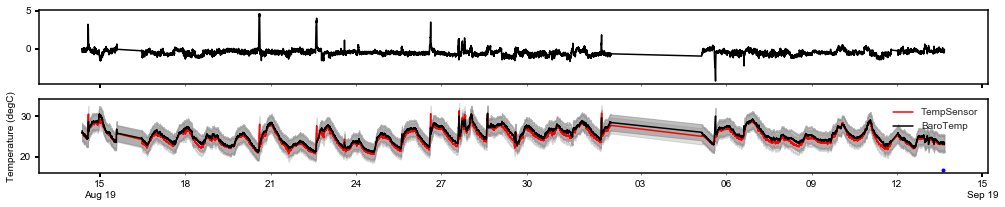

In [343]:
fig, (ax2, ax1) = plt.subplots(2,1,sharex='col',figsize=(17,3))
ax1.plot(df.index,df['Temp'],'r',df.index,df['BaroTemp'],'k')
ax1.fill_between(df.index,df['Temp']-2,df['Temp']+2,color='grey',alpha=.25)
ax1.fill_between(df.index,df['BaroTemp']-2,df['BaroTemp']+2,color='grey',alpha=.5)
ax2.plot(df.index,df['Temp']-df['BaroTemp'],'k')
plt.ylabel('Temperature (degC)')


try:
    pass
    ax1.plot(kbfi['datetime'],np.float(kbfi['temp_c']),'ob',markersize=3)
except:
    pass

plt.legend(['TempSensor','BaroTemp'])
#ax1.set_xlim(df.index[0], df.index[-1])
xfmt = mdates.DateFormatter('%d-%b')
ax1.xaxis.set_major_locator(DayLocator(bymonthday=15))
ax1.xaxis.set_minor_locator(DayLocator(range(0,32,3)))
ax1.xaxis.set_minor_formatter(DateFormatter('%d'))
ax1.xaxis.set_major_formatter(DateFormatter('%d\n%b %y'))
ax1.xaxis.set_tick_params(which='major', pad=3)
ax1.xaxis.set_tick_params(which='minor', pad=5)

print(f"Average difference between two sensors for all time: {(df['Temp']-df['BaroTemp']).mean()}")
two_weeks_delta = (df['Temp'][df.last_valid_index()-pd.DateOffset(14, 'D'):] - 
                  df['BaroTemp'][df.last_valid_index()-pd.DateOffset(14, 'D'):]).mean()
print(f"Average difference between two sensors for last two weeks: {two_weeks_delta}")

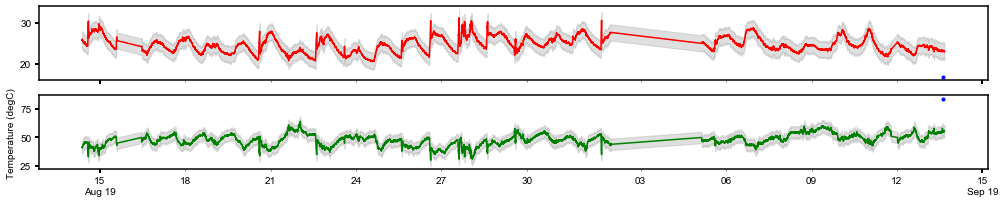

In [344]:
fig, (ax2, ax1) = plt.subplots(2,1,sharex='col',figsize=(17,3))
ax1.plot(df.index,df['RH_Percent'],'g')
ax1.fill_between(df.index,df['RH_Percent']-5,df['RH_Percent']+5,color='grey',alpha=.25)
ax2.plot(df.index,df['Temp'],'r')
ax2.fill_between(df.index,df['Temp']-2,df['Temp']+2,color='grey',alpha=.25)
plt.ylabel('Temperature (degC)')

try:
    pass
    ax1.plot(kbfi['datetime'],np.float(kbfi['relative_humidity']),'ob',markersize=3)
    ax2.plot(kbfi['datetime'],np.float(kbfi['temp_c']),'ob',markersize=3)
except:
    pass

xfmt = mdates.DateFormatter('%d-%b')
ax1.xaxis.set_major_locator(DayLocator(bymonthday=15))
ax1.xaxis.set_minor_locator(DayLocator(range(0,32,3)))
ax1.xaxis.set_minor_formatter(DateFormatter('%d'))
ax1.xaxis.set_major_formatter(DateFormatter('%d\n%b %y'))
ax1.xaxis.set_tick_params(which='major', pad=3)
ax1.xaxis.set_tick_params(which='minor', pad=5)

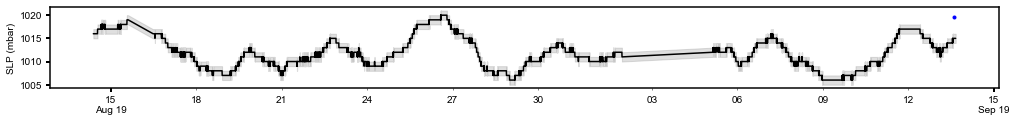

In [345]:
fig, ax1 = plt.subplots(1,1,sharex='col',figsize=(17,1.5))
ax1.plot(df.index,df['SLP'],'k')
ax1.fill_between(df.index,df['SLP']-1,df['SLP']+1,color='grey',alpha=.25)
plt.ylabel('SLP (mbar)')

try:
    pass
    ax1.plot(kbfi['datetime'],np.float(kbfi['pressure_mb']),'ob',markersize=3)
except:
    pass

xfmt = mdates.DateFormatter('%d-%b')
ax1.xaxis.set_major_locator(DayLocator(bymonthday=15))
ax1.xaxis.set_minor_locator(DayLocator(range(0,32,3)))
ax1.xaxis.set_minor_formatter(DateFormatter('%d'))
ax1.xaxis.set_major_formatter(DateFormatter('%d\n%b %y'))
ax1.xaxis.set_tick_params(which='major', pad=3)
ax1.xaxis.set_tick_params(which='minor', pad=5)

In [346]:
### build a table of daily max/min
daily_summary = pd.DataFrame(columns=df.columns)

for column in daily_summary:
    daily_summary[column+' (min)'] = df[column].resample('D').min()
    daily_summary[column+' (max)'] = df[column].resample('D').max()
    daily_summary[column+' (median)'] = df[column].resample('D').median()
    daily_summary[column] = df[column].resample('D').mean()
    


In [347]:
def highlight_max(s):
    '''
    highlight the maximum in a Series red.
    '''
    is_max = s == s.max()
    return ['color: red' if v else '' for v in is_max]

def highlight_min(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_min = s == s.min()
    return ['color: blue' if v else '' for v in is_min]



In [348]:
daily_summary.style.apply(highlight_max).apply(highlight_min).format("{:.2f}")

,Temp,RH_Percent,BaroTemp,SLP,Temp (min),Temp (max),Temp (median),RH_Percent (min),RH_Percent (max),RH_Percent (median),BaroTemp (min),BaroTemp (max),BaroTemp (median),SLP (min),SLP (max),SLP (median)
time (UTC),,,,,,,,,,,,,,,,
2019-08-14 00:00:00+00:00,27.10,41.95,27.29,1016.94,24.30,30.50,27.60,33.00,46.00,42.00,24.30,30.50,27.85,1016.00,1018.00,1017.00
2019-08-15 00:00:00+00:00,25.89,46.12,26.29,1017.59,23.50,29.10,25.60,40.00,51.00,47.00,23.60,30.30,25.90,1017.00,1019.00,1018.00
2019-08-16 00:00:00+00:00,23.94,47.80,24.50,1015.39,22.10,25.90,23.70,43.00,54.00,48.00,22.80,26.50,24.30,1013.00,1016.00,1016.00
2019-08-17 00:00:00+00:00,24.47,48.69,24.98,1011.80,22.60,26.50,24.60,43.00,55.00,49.00,23.00,27.00,25.00,1010.00,1013.00,1012.00
2019-08-18 00:00:00+00:00,24.24,48.40,24.98,1008.21,22.10,26.70,24.30,43.00,54.00,48.00,23.10,27.40,24.80,1007.00,1010.00,1008.00
2019-08-19 00:00:00+00:00,23.48,48.90,23.85,1009.78,22.00,25.20,23.20,43.00,54.00,49.00,22.20,25.60,23.60,1007.00,1013.00,1010.00
2019-08-20 00:00:00+00:00,24.22,43.90,24.53,1009.95,20.90,28.00,24.40,34.00,51.00,43.00,21.10,28.30,24.70,1007.00,1012.00,1010.00
2019-08-21 00:00:00+00:00,23.78,50.27,24.25,1009.78,20.70,28.00,23.00,39.00,61.00,51.00,21.90,28.40,23.40,1007.00,1011.00,1010.00
2019-08-22 00:00:00+00:00,23.58,49.37,23.89,1012.86,20.70,27.60,23.20,35.00,64.00,52.00,21.10,27.70,23.50,1010.00,1015.00,1013.00


In [349]:
(daily_summary - daily_summary.mean()).style.bar(align='mid', color=['#d65f5f', '#5fba7d'])


,Temp,RH_Percent,BaroTemp,SLP,Temp (min),Temp (max),Temp (median),RH_Percent (min),RH_Percent (max),RH_Percent (median),BaroTemp (min),BaroTemp (max),BaroTemp (median),SLP (min),SLP (max),SLP (median)
time (UTC),,,,,,,,,,,,,,,,
2019-08-14 00:00:00+00:00,2.3633,-5.95574,2.04035,4.90353,1.80714,2.75,2.94286,-7.03571,-8.21429,-6.28571,1.28571,2.43929,2.67679,6.32143,4.10714,4.92857
2019-08-15 00:00:00+00:00,1.15408,-1.7857,1.04544,5.55091,1.00714,1.35,0.942857,-0.0357143,-3.21429,-1.28571,0.585714,2.23929,0.726786,7.32143,5.10714,5.92857
2019-08-16 00:00:00+00:00,-0.792647,-0.105276,-0.747641,3.35353,-0.392857,-1.85,-0.957143,2.96429,-0.214286,-0.285714,-0.214286,-1.56071,-0.873214,3.32143,2.10714,3.92857
2019-08-17 00:00:00+00:00,-0.266119,0.789045,-0.264607,-0.23558,0.107143,-1.25,-0.0571429,2.96429,0.785714,0.714286,-0.0142857,-1.06071,-0.173214,0.321429,-0.892857,-0.0714286
2019-08-18 00:00:00+00:00,-0.489396,0.490922,-0.269709,-3.82936,-0.392857,-1.05,-0.357143,2.96429,-0.214286,-0.285714,0.0857143,-0.660714,-0.373214,-2.67857,-3.89286,-4.07143
2019-08-19 00:00:00+00:00,-1.25397,0.991538,-1.39771,-2.25894,-0.492857,-2.55,-1.45714,2.96429,-0.214286,0.714286,-0.814286,-2.46071,-1.57321,-2.67857,-0.892857,-2.07143
2019-08-20 00:00:00+00:00,-0.514873,-4.00768,-0.712893,-2.09306,-1.59286,0.25,-0.257143,-6.03571,-3.21429,-5.28571,-1.91429,0.239286,-0.473214,-2.67857,-1.89286,-2.07143
2019-08-21 00:00:00+00:00,-0.956696,2.36148,-0.994202,-2.25817,-1.79286,0.25,-1.65714,-1.03571,6.78571,2.71429,-1.11429,0.339286,-1.77321,-2.67857,-2.89286,-2.07143
2019-08-22 00:00:00+00:00,-1.15644,1.47022,-1.3544,0.824495,-1.79286,-0.15,-1.45714,-5.03571,9.78571,3.71429,-1.91429,-0.360714,-1.67321,0.321429,1.10714,0.928571
